# Analyzing Conditions to Win a League of Legends Match

Yuhwan Lee, Margaret Fang

## Introduction

League of Legends, commonly known as League or LoL, is a multiplayer online battle arena (MOBA) video game developed by Riot Games. It was released in 2009 and has become one of the most popular video games in the world. As of September 2022, there are more than 180 million active monthly users. The game is available on Windows and MacOS, and the modified mobile version called Wild Rift is available on android and iOS.  Because of the game's popularity, music videos, comic books, short stories, an animated series (Arcane), and several spin-off video games (Legends of Runeterra, Team Fight Tactics, etc.) have been made. Additionally, League of Legends is regularly cited as the world's largest esport as the 2019 League of Legends World Championship had 100 million unique viewers and peaked at 44 million concurrent viewers. 

There are a few gamemodes in League of Legends, but we will be focusing on the primary gamemode, Summoner's Rift. Two teams of five players compete and face off at opposing sides of the map. Each player controls a character, known as a champion, with unique abilities and playstyle. The objective of the game is to destroy the opposing team's Nexus, which is at the heart of the base. The Nexus is protected by towers and inhibitors. Minions are spawned by the Nexus and move towards the enemy base in waves along each lane. There are three lanes (top, middle, and bottom), and the area between lanes is called the jungle where neutral monsters are. Killing minions and neutral monsters gives players experience and gold, which they can use to level up skills and buy items from the shop to power up their champion. There are several large monsters (Rift Herald, Baron Nashor, Dragons) that can give buffs to a team when killed. More information on how to play the game can be found at https://www.leagueoflegends.com/en-us/how-to-play/. 

In this tutorial, our goal is to gather data on League of Legends Season 12 ranked matches from Iron to Diamond, organize the data, analyze some aspects that can contribute to winning a game, and compare those aspects across the ranks. League is constantly evolving. Every two weeks, a new patch comes out where bugs are fixed and new features and balances are made. Champions and items are constantly being buffed/nerfed and reworked. Because of the everchanging meta and large number of champions and items, we decided to focus on more patch agnostic factors such as map fairness, pings, objectives, and farming. League of Legends has a very steep learning curve and many aspects to the game. We hope that we will be able to help players understand what is important to winning and how to play like highly ranked players. Although it is much easier to understand our analysis with game knowledge, we hope that this tutorial can make readers who are unfamiliar with the game more interested in trying out League of Legends.

## Table of Contents

>[Analyzing Conditions to Win a League of Legends Match](#scrollTo=7XzhaWj0FZAu)

>>[Introduction](#scrollTo=R2uF9yGyTUeB)

>>[Table of Contents](#scrollTo=fUYwiCuKXS-_)

>>[Getting Started](#scrollTo=FANbosgSUQ0-)

>[Data Collection](#scrollTo=MKgoZzPzTn8K)

>>[Riot API](#scrollTo=DTLmqHP5WZaP)

>>[Match Data](#scrollTo=yjWZPEODbiea)

>>[Creating DataFrame](#scrollTo=YrcyyrTqbzRp)

>>[Tidying Data](#scrollTo=ih1c_KlfZZL9)

>[Data Analysis](#scrollTo=_6_I-KW8bbmm)

>>[Blue Side vs Red Side](#scrollTo=ez0CXoJipK53)

>>[Crowd Control](#scrollTo=vhohdwUQc4ap)

>>[Pings](#scrollTo=7g_nm_FoxzpX)

>>[Vision](#scrollTo=OMMRHZUY4Yfa)

>>[Objectives](#scrollTo=g41eY1Z2pQqt)

>>[Farming](#scrollTo=5108Hq6np-Ko)

>>[Tying it Together](#scrollTo=5LiDE3a4zbvi)

>[Conclusion](#scrollTo=T8HMdeGZgUi3)

>>[Findings](#scrollTo=uyWI6uQk78Tf)

>>[Further Exploration](#scrollTo=zUHXok_AgZK1)



## Getting Started

We use Python 3 with the following imported libraries listed below. Additionally, we are using Google Colab to run this Notebook, and we mount this notebook to our Google Drive, so that we can save files and access them later. We create a folder in our Google Drive at "drive/MyDrive/google_colab_data/" to store files, which will be explained in more detail later.

In [343]:
import requests
import json
import random
import os
import time
import itertools
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import statistics
from scipy import stats
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz


import warnings
warnings.filterwarnings("ignore")

In [344]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Collection

Because we were unable to find a relevant and large dataset of League of Legends match data, we decided to create our own dataset by making calls to the Riot API and taking data from the Riot database. This allows us to be able to collect as much data as we need and filter on certain aspects like rank and season.

## Riot API

The Riot API and documentation can be accessed at https://developer.riotgames.com/, and you need a free Riot account to get an API key. A new API key can be generated at any time, and it expires after 24 hours.

In our analysis, we look at ranked SOLO/DUO queue matches from the North America server. We only look at matches from the ranks Iron, Silver, Gold, Platinum, and Diamond because Master, Grandmaster, and Challenger games are a little different and must be accessed with a different API endpoint.

In [345]:
# Reminder that default API key expires after 24 hours
API_KEY = "RGAPI-327d2787-6630-4cc3-a83c-9d523d0659a9"

# North America server
URL = "https://na1.api.riotgames.com"
AMERICAS_ROUTING_URL = "https://americas.api.riotgames.com"

# Queue ids: https://static.developer.riotgames.com/docs/lol/queues.json
QUEUE_ID = 420
QUEUE = "RANKED_SOLO_5x5"

# Ranked tiers and divisons
TIERS = ["IRON", "BRONZE", "SILVER", "GOLD", "PLATINUM", "DIAMOND"]
DIVISIONS = ["IV", "III", "II", "I"]
RANKED_ORDER = []
for tier in TIERS:
  for division in DIVISIONS:
    RANKED_ORDER.append(tier + "_" + division)

The Riot API has rate limits in place of 20 requests every 1 second and 100 requests every 2 minutes. To ensure that we do not surpass these rate limits, we create a global variable num_api_calls and a function wait_api_rate_limits(), which keeps track of the number of API calls and sleeps for an appropriate amount of time after we have hit the rate limits. Each time we make an API call, we can call this method to help us manage rate limits.

In [346]:
# Keep track of the number of API calls for rate limiting
# Riot API allows for 20 requests every second, and 100 requests every 2 minutes
num_api_calls = 0

# Wait for API calls
def wait_api_rate_limits():
  global num_api_calls
  # print("num", num_api_calls)
  num_api_calls += 1

  if num_api_calls % 20 == 0:
    time.sleep(1)  # Sleep 1 second for every 20 api calls

  if num_api_calls % 100 == 0:
    print(f"Reached {num_api_calls} calls, sleeping for 2 minutes")
    time.sleep(120)  # Sleep 2 minutes for every 100 api calls

There is no endpoint that will get a certain number of matches from a rank. Because the Riot API is very limited, the process to get a list of matches per rank is very long and requires many API calls. 

1. We first get a list of players' summoner IDs from a certain rank with the endpoint "/lol/league/v4/entries/{queue}/{tier}/{division}". 
2. We get each player's puuid with the endpoint "/lol/summoner/v4/summoners/{encryptedSummonerId}".
3. We get a list of recent match IDs from each player with the endpoint "/lol/match/v5/matches/by-puuid/{puuid}/ids"
4. We get match data for each match with the endpoint "/lol/match/v5/matches/{matchId}"

Below are the functions we create for each API call to help our code be more readable. Note that to get matches from each player, we get 100 matches from 02/01/2022 to 10/30/2022, which would be League of Legends Season 12. Then, we get a random sample of 5 matches from those 100 matches.

In [347]:
# Get a list of summoners given a specific tier and division
def get_summoner_ids(tier, division, count):
  summoner_ids = []
  url = f"{URL}/lol/league/v4/entries/{QUEUE}/{tier}/{division}"
  params = {"api_key" : API_KEY}

  wait_api_rate_limits()
  r = requests.get(url, params=params)
  if not r.ok:  # If response is an error
    print(r.content)

  # This endpoint returns 205 entries per page - page is a query parameter that can be passed
  data = json.loads(r.content)
  
  for entry in data:
    if len(summoner_ids) == count:
      break
    summoner_ids.append(str(entry["summonerId"]))

  return summoner_ids

# Get the corresponding puuids of users given a list of summoner ids
def get_puuids(summoner_ids):
  puuids = []
  
  for summoner_id in summoner_ids:
    url = f"{URL}/lol/summoner/v4/summoners/{summoner_id}"
    params = {"api_key" : API_KEY}

    wait_api_rate_limits()
    r = requests.get(url, params=params)
    if not r.ok:  # If response is an error
      print(r.content)

    data = json.loads(r.content)

    puuids.append(data["puuid"])

  return puuids

# Get a list of ranked matches played by a list of players
# For each user, get 100 matches from 02/01/2022 to 10/30/2022, and take
# a random sample of 5 matches from those matches
def get_match_ids_by_puuids(puuids):
  match_ids = []

  for puuid in puuids:
    url = f"{AMERICAS_ROUTING_URL}/lol/match/v5/matches/by-puuid/{puuid}/ids"
    params = {
        "api_key" : API_KEY,
        "queue": QUEUE_ID,
        "startTime": 1643691600,  # 02/01/2022 12:00:00am
        "endTime": 1667088000,    # 10/30/2022 12:00:00am
        "count": 100
      }

    wait_api_rate_limits()
    r = requests.get(url, params=params)
    if not r.ok:  # If response is an error
      print(r.content)

    # List of strings, by default returns 20 strings, can set count from 0 to 100
    # Also has parameters start time and end time, and queue
    data = json.loads(r.content)

    # Get random sample of 5 matches from this list
    if len(data) >= 5:
      data = random.sample(data, 5)
    match_ids.extend(data)

  return match_ids

# Get match data given a list of match ids
def get_matches_by_match_ids(match_ids):
  matches = []
  for match_id in match_ids:
    url = f"{AMERICAS_ROUTING_URL}/lol/match/v5/matches/{match_id}"
    params = {
        "api_key" : API_KEY,
      }
    wait_api_rate_limits()
    r = requests.get(url, params=params)
    if not r.ok:  # If response is an error
      print(r.content)
    data = json.loads(r.content)
    matches.append(data)
  return matches

Now, we finally make the API calls and collect the data. For each tier and division, we first get a list of 100 players' summoner IDs (who are in that tier and division) and get their puuids. Next, we get 5 random Season 12 ranked matches from each user and get match data for each match. The data is written to a json file and saved. There is a separate json file for each tier and division. 

The entire runtime of making the API calls and collecting data takes several hours because of rate limits. Because we want the files to be stored in a permanent location, we download the json files and upload them to the folder "drive/MyDrive/google_colab_data/". At the end of the code block below, the call to downloaded_data() is commented out since we only need to do this process once.

In [348]:
def download_data():
  for tier in TIERS:
    for division in DIVISIONS:
      print(f"On {tier} {division}")
      # Get a list of 100 summoners by tier and division (1 API call)
      print("getting summoner ids")
      summoner_ids = get_summoner_ids(tier, division, 100)
      # Get the corresponding puuids of each summoner returned (100 API calls)
      print("getting puuids")
      puuids = get_puuids(summoner_ids)
      # Get 5 random ranked matches from each user (100 API calls)
      print("getting match ids")
      match_ids = get_match_ids_by_puuids(puuids)
      # Get match data for each match id (5*100 = 500 API Calls)
      print("getting matches")
      match_data = get_matches_by_match_ids(match_ids)
      print("number of matches found:", len(match_data))
      # Write match data to a file
      with open(f"{tier}_{division}_matches.json", "w") as file:
        json.dump(match_data, file)

# download_data()

## Match Data

The data for each match is very extensive. The print statements below show the data stored at different parts of the json, and they have been commented out due to the lengthy output. 

We find the following sections to contain worthwhile information.

*   match["info"]["gameDuration"] - Contains the game duration.
*   match["info"]["teams"] - Contains information about champion bans and objectives (baron, dragon, rift herald, towers, inhibitors) that each team has taken.
*   json.dumps(match["info"]["participants"] - Contains information for each individual player in the game such as role, champion, kills, deaths, assists, damage, gold earned, experience earned, creep score, vision score, etc. 

There is much more data saved, but we have picked what we think is important in our analysis, which is all information on objectives from team data and the statistics listed in participants data above.

In [349]:
with open("drive/MyDrive/google_colab_data/PLATINUM_IV_matches.json", "r") as file:
  data = json.load(file)
  match = data[0]
  # print(json.dumps(match, indent=4))

# print(match.keys())
# print(match["metadata"])
# print(match["info"].keys())
# print(json.dumps(match["info"]["gameDuration"]))
# print(json.dumps(match["info"]["gameType"]))
# print(json.dumps(match["info"]["gameVersion"]))
# print(json.dumps(match["info"]["platformId"]))
# print(json.dumps(match["info"]["mapId"]))
# print(json.dumps(match["info"]["teams"], indent=4))
# print(json.dumps(match["info"]["participants"][0], indent=4))

## Creating DataFrame

We must pull out relevant data and convert it to a pandas dataframe for ease of data access and analysis. We loop through the tiers and divisions to access each json file and then pull relevant data into a 2D array. For data in participant data, we iterate through each participant and add to the blue and red team accordingly because our analysis is more focused on the entire team rather than an individual's performance. We then convert our 2D array into a Pandas dataframe.

In [350]:
all_data = {
    "teamWin": [],
    "gameRankDivision": [],
    "gameRank": [],
    "gameDivision": [],
    "gameDuration": [],
    "blueFirstBaron": [],
    "blueNumBaron": [],
    "blueFirstChampion": [],
    "blueNumChampion": [],
    "blueFirstDragon": [],
    "blueNumDragon": [],
    "blueFirstInhibitor": [],
    "blueNumInhibitor": [],
    "blueFirstRiftHerald": [],
    "blueNumRiftHerald": [],
    "blueFirstTower": [],
    "blueNumTower": [],

    "blueNumPings": [],
    "blueNumAssists": [],
    "blueTotalExp": [],
    "blueTotalGold": [],
    "blueTotalCC": [],
    "blueTotalDamage": [],
    "blueTotalCS": [],
    "blueTotalVisionScore": [],

    "redFirstBaron": [],
    "redNumBaron": [],
    "redFirstChampion": [],
    "redNumChampion": [],
    "redFirstDragon": [],
    "redNumDragon": [],
    "redFirstInhibitor": [],
    "redNumInhibitor": [],
    "redFirstRiftHerald": [],
    "redNumRiftHerald": [],
    "redFirstTower": [],
    "redNumTower": [],

    "redNumPings": [],
    "redNumAssists": [],
    "redTotalExp": [],
    "redTotalGold": [],
    "redTotalCC": [],
    "redTotalDamage": [],
    "redTotalCS": [],
    "redTotalVisionScore": []
}

# Convert data into dictionary
# Iterate through tiers and divisions
for tier in TIERS:
  for division in DIVISIONS:
    # Open json file in Google Drive
    with open(f"drive/MyDrive/google_colab_data/{tier}_{division}_matches.json", "r") as file:
      data = json.load(file)

      for match in data:
        # Handles missing data
        if len(match["info"]["teams"]) < 2:
          continue

        all_data["gameDuration"].append(match["info"]["gameDuration"])
        all_data["gameRankDivision"].append(tier + "_" + division)
        all_data["gameRank"].append(tier)
        all_data["gameDivision"].append(division)

        # Team_data contains two objects, one for each team
        team_data = match["info"]["teams"]
        # Make sure blue team comes first in the list
        team_data.sort(key=lambda team: team["teamId"])
        for team in team_data:
          team_name = "blue" if team["teamId"] == 100 else "red"

          # Adds team that won
          if team["win"]:
            all_data["teamWin"].append(team_name)

          # Add all team related data
          # Data about objectives taken
          for objective_name in team["objectives"]:
            # Capitalize name of objective for dictionary key
            cap_obj_name = objective_name[:1].upper() + objective_name[1:]
            all_data[f"{team_name}First{cap_obj_name}"].append(team["objectives"][objective_name]["first"])
            all_data[f"{team_name}Num{cap_obj_name}"].append(team["objectives"][objective_name]["kills"])


        # Data in participant data
        participant_data = {"blueNumPings": 0, "blueNumAssists": 0, "blueTotalExp": 0, "blueTotalGold": 0,
                            "blueTotalCC": 0, "blueTotalDamage": 0, "blueTotalCS": 0, "blueTotalVisionScore": 0,
                            "redNumPings": 0, "redNumAssists": 0, "redTotalExp": 0, "redTotalGold": 0,
                            "redTotalCC": 0, "redTotalDamage": 0, "redTotalCS": 0, "redTotalVisionScore": 0
                            }

        # Iterate through participants
        for participant in match["info"]["participants"]:
          team_name = "blue" if participant["teamId"] == 100 else "red"
          participant_data[f"{team_name}NumPings"] += participant["basicPings"] if "basicPings" in participant.keys() else 0 # Handles missing data
          participant_data[f"{team_name}NumAssists"] += participant["assists"]
          participant_data[f"{team_name}TotalExp"] += participant["champExperience"]
          participant_data[f"{team_name}TotalGold"] += participant["goldEarned"]
          participant_data[f"{team_name}TotalCC"] += participant["timeCCingOthers"]
          participant_data[f"{team_name}TotalDamage"] += participant["totalDamageDealtToChampions"]
          participant_data[f"{team_name}TotalCS"] += participant["totalMinionsKilled"] + participant["neutralMinionsKilled"]
          participant_data[f"{team_name}TotalVisionScore"] += participant["visionScore"]

        # Adds to all data
        for key in participant_data:
          all_data[key].append(participant_data[key])

In [351]:
# Build pandas DataFrame from dictionary
match_df = pd.DataFrame.from_dict(all_data)
match_df.head()

,teamWin,gameRankDivision,gameRank,gameDivision,gameDuration,blueFirstBaron,blueNumBaron,blueFirstChampion,blueNumChampion,blueFirstDragon,...,redFirstTower,redNumTower,redNumPings,redNumAssists,redTotalExp,redTotalGold,redTotalCC,redTotalDamage,redTotalCS,redTotalVisionScore
0,blue,IRON_IV,IRON,IV,2103,True,1,True,39,False,...,False,4,147,21,71283,57043,56,91163,805,136
1,blue,IRON_IV,IRON,IV,1688,True,1,False,34,True,...,True,6,59,28,49651,47421,41,64165,585,101
2,red,IRON_IV,IRON,IV,1465,False,0,False,15,False,...,True,11,55,18,51099,45670,49,52085,609,80
3,blue,IRON_IV,IRON,IV,963,False,0,True,17,True,...,False,0,22,4,25951,19354,47,18135,295,26
4,red,IRON_IV,IRON,IV,2014,False,0,True,26,False,...,True,9,121,45,73586,65526,122,111373,678,127


## Tidying Data

1. A typical League of Legends match is around 20-40 minutes long. Games that end before 5 minutes are not a good representation of data, as they most likely occur due to a player disconnecting or idling. Thus, we remove all games under 5 minutes from our data. 

2. We also rename some of our columns so that it is more intuitive. NumChampion stands for the number of kills and FirstChampion indicates if the team had the first kill in the game, which is a term called first blood in the game. Let us rename these columns to NumKills and FirstBlood.

4. We make sure that the gameRankDivision has ordered categorical data because the ranks are ordered from IRON IV to DIAMOND 1.

In [352]:
print("Number of games:", len(match_df))
print("Number of games lasting less than 3 minutes:", len(match_df[match_df["gameDuration"] < 180]))
print("Number of games lasting less than 5 minutes:", len(match_df[match_df["gameDuration"] < 300]))
print("Number of games lasting less than 15 minutes:", len(match_df[match_df["gameDuration"] < 900]))

# Games lasting less than 5 minutes are bogus, so we will just remove them.
match_df = match_df[match_df["gameDuration"] > 300]

# Rename some columns for better readibility
match_df = match_df.rename(columns = {"blueNumChampion" : "blueNumKills", "redNumChampion" : "redNumKills", 
                           "blueFirstChampion" : "blueFirstBlood", "redFirstChampion" : "redFirstBlood"})

# Make game rank ordered
match_df.gameRankDivision = pd.Categorical(match_df.gameRankDivision, 
                      categories=RANKED_ORDER,
                      ordered=True)
match_df.gameRank = pd.Categorical(match_df.gameRank, 
                      categories=TIERS,
                      ordered=True)

match_df.head()

Number of games: 11572
Number of games lasting less than 3 minutes: 0
Number of games lasting less than 5 minutes: 118
Number of games lasting less than 15 minutes: 261


,teamWin,gameRankDivision,gameRank,gameDivision,gameDuration,blueFirstBaron,blueNumBaron,blueFirstBlood,blueNumKills,blueFirstDragon,...,redFirstTower,redNumTower,redNumPings,redNumAssists,redTotalExp,redTotalGold,redTotalCC,redTotalDamage,redTotalCS,redTotalVisionScore
0,blue,IRON_IV,IRON,IV,2103,True,1,True,39,False,...,False,4,147,21,71283,57043,56,91163,805,136
1,blue,IRON_IV,IRON,IV,1688,True,1,False,34,True,...,True,6,59,28,49651,47421,41,64165,585,101
2,red,IRON_IV,IRON,IV,1465,False,0,False,15,False,...,True,11,55,18,51099,45670,49,52085,609,80
3,blue,IRON_IV,IRON,IV,963,False,0,True,17,True,...,False,0,22,4,25951,19354,47,18135,295,26
4,red,IRON_IV,IRON,IV,2014,False,0,True,26,False,...,True,9,121,45,73586,65526,122,111373,678,127


Now we have data split between blue and red team. To perform analysis on what factors contribute to a win, we will "normalize" the data by taking the difference of the winning team's value of a certain stat by the losing team's corresponding value, e.g. if blue won, we would take blueNumChampion - redNumChampion. We will also normalize the data in the perspective of blue side, so that the difference will always be blue minus red.

In [353]:
# Dataframe where all values are relative to winning team
normalized_data = {
    "teamWin": [],
    "gameRankDivision": [],
    "gameRank": [],
    "gameDivision": [],
    "gameDuration": []
}

# Dataframe where all values are relative to blue team
blue_side_data = {
    "teamWin": [],
    "gameRankDivision": [],
    "gameRank": [],
    "gameDivision": [],
    "gameDuration": []
}

# Create difference fields
team_stat_names = list(map(lambda blue_field_name: blue_field_name[4:], filter(lambda field: field.startswith("blue"), match_df)))
for team_stat in team_stat_names:
  normalized_data["diff" + team_stat] = []
  blue_side_data["diff" + team_stat] = []

# Go row by row and calculate these new fields
for index, row in match_df.iterrows():
  # teamWin will be 1 if blue won the game, 0 if red won
  teamWin = row["teamWin"]
  normalized_data["teamWin"].append(int(row["teamWin"] == "blue"))
  normalized_data["gameRankDivision"].append(row["gameRankDivision"])
  normalized_data["gameRank"].append(row["gameRank"])
  normalized_data["gameDivision"].append(row["gameDivision"])
  normalized_data["gameDuration"].append(row["gameDuration"])

  blue_side_data["teamWin"].append(int(row["teamWin"] == "blue"))
  blue_side_data["gameRankDivision"].append(row["gameRankDivision"])
  blue_side_data["gameRank"].append(row["gameRank"])
  blue_side_data["gameDivision"].append(row["gameDivision"])
  blue_side_data["gameDuration"].append(row["gameDuration"])

  for team_stat in team_stat_names:
    # Boolean stats are treated differently
    # A boolean that is true for blue will always be false for red, and vice versa
    # So, true for winning team will correspond to 1 in our normalized data

    # If this is a boolean field:
    if type(row["blue" + team_stat]) == type(True):
      normalized_data["diff" + team_stat].append(int(row[teamWin + team_stat]))
      blue_side_data["diff" + team_stat].append(int(row["blue" + team_stat]))
    else:
      teamLose = "red" if teamWin == "blue" else "blue"
      normalized_data["diff" + team_stat].append(
          row[teamWin + team_stat] - row[teamLose + team_stat]
      )
      blue_side_data["diff" + team_stat].append(
          row["blue" + team_stat] - row["red" + team_stat]
      )

In [354]:
normalized_df = pd.DataFrame.from_dict(normalized_data)
blue_side_df = pd.DataFrame.from_dict(blue_side_data)

# Make game rank ordered
normalized_df.gameRankDivision = pd.Categorical(normalized_df.gameRankDivision, 
                      categories=RANKED_ORDER,
                      ordered=True)
normalized_df.gameRank = pd.Categorical(normalized_df.gameRank, 
                      categories=TIERS,
                      ordered=True)

blue_side_df.gameRankDivision = pd.Categorical(blue_side_df.gameRankDivision, 
                      categories=RANKED_ORDER,
                      ordered=True)
blue_side_df.gameRank = pd.Categorical(blue_side_df.gameRank, 
                      categories=TIERS,
                      ordered=True)

normalized_df.head()

,teamWin,gameRankDivision,gameRank,gameDivision,gameDuration,diffFirstBaron,diffNumBaron,diffFirstBlood,diffNumKills,diffFirstDragon,...,diffFirstTower,diffNumTower,diffNumPings,diffNumAssists,diffTotalExp,diffTotalGold,diffTotalCC,diffTotalDamage,diffTotalCS,diffTotalVisionScore
0,1,IRON_IV,IRON,IV,2103,1,1,1,21,0,...,1,7,-133,4,1034,8430,171,14534,0,-53
1,1,IRON_IV,IRON,IV,1688,1,1,0,8,1,...,0,4,23,-5,13894,7649,-1,13638,-21,-47
2,0,IRON_IV,IRON,IV,1465,0,0,1,4,1,...,1,11,-2,10,9805,13633,23,15673,242,41
3,1,IRON_IV,IRON,IV,963,0,0,1,13,1,...,1,3,36,9,6034,9783,-5,12810,58,18
4,0,IRON_IV,IRON,IV,2014,1,2,0,18,1,...,1,4,-51,8,4963,9776,-62,18737,81,9


# Data Analysis

## Blue Side vs Red Side


The first thing we will explore is the difference between blue side and red side. In League of Legends, the map is almost symmetrical, with a few differences. Ideally, the side should not matter for players, and the win rates for both sides should be around 50%. However, the playerbase seems to prefer being on blue side because there are nuances with camera angle and the HUD (display bar) being on the bottom side, which may make playing on the red side more uncomfortable. Blue side is also the side that new players start out on (all tutorials and bot games).

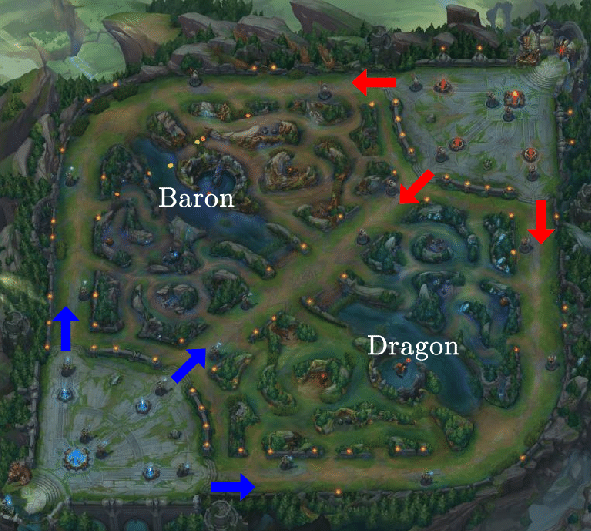

From: https://www.researchgate.net/figure/Map-of-Summoners-Rift_fig1_339003417

In [355]:
# Display percentage of blue wins and red wins
match_df["teamWin"].value_counts(normalize=True)

blue    0.512572
red     0.487428
Name: teamWin, dtype: float64

We see that on average, blue side has a slightly higher winrate. Let us determine if this difference is significant. The graphic below shows us which hypothesis test to use. We use a right-tailed one sample T test to check whether or not the true average value of team win is statistically greater than 0.5. Remember that the teamWin column has 0 for red side winning and 1 for blue side winning. Essentially, we are checking if the blue side winrate is statistically greater than 50%. We use scipy package to perform the hypothesis test.

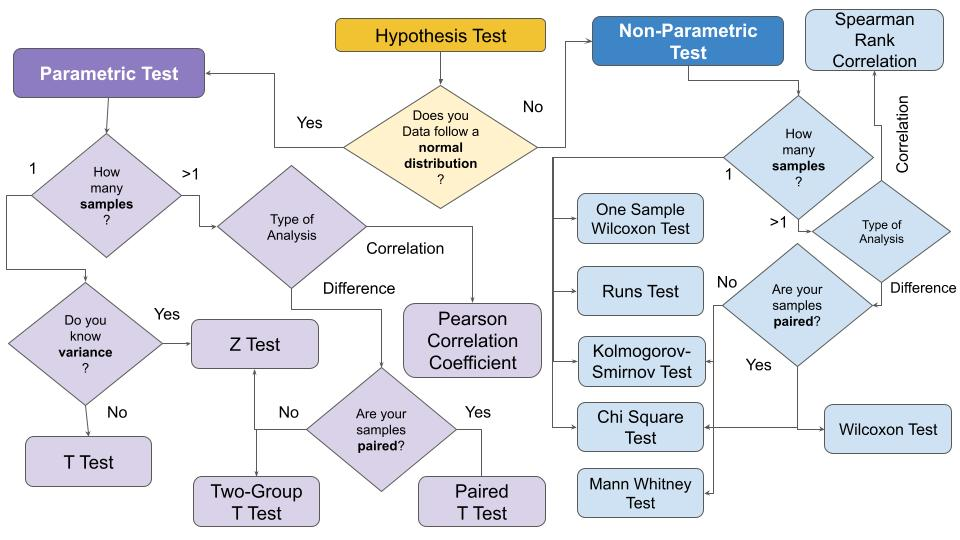

From: https://www.kdnuggets.com/2021/09/hypothesis-testing-explained.html

In [356]:
# Right-tailed one sample T test
stats.ttest_1samp(normalized_df["teamWin"], popmean=0.5, alternative="greater")

Ttest_1sampResult(statistic=2.691734794007755, pvalue=0.003559236277464431)

Since the p-value is less than a significance level of 0.05, we can conclude that the win percentage of blue side is statistically greater than 50%. Wow, looks like the map is not fair!

Next, let us see how rank affects the blue side winrate. It is possible that higher ranked players are able to play effectively on both blue and red side which would lead to a blue side winrate closer to 50%.

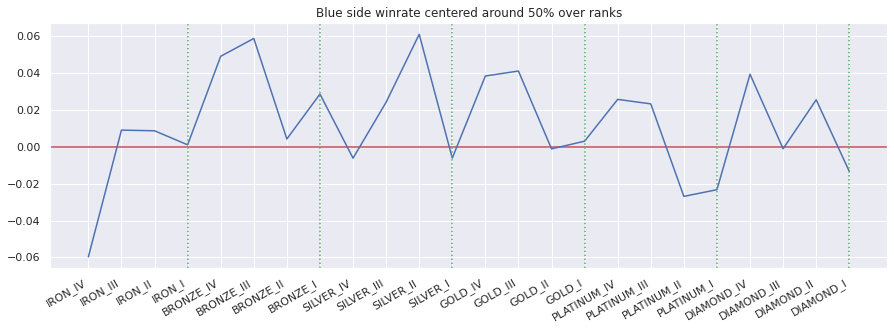

In [357]:
# Get blue side winrate minus 0.5 for each rank
val_counts = match_df.groupby("gameRankDivision")["teamWin"].value_counts(normalize=True)
arr = []
for rank in RANKED_ORDER:
  arr.append(val_counts[rank]["blue"] - .5)
  # Prints out rank that blue side winrate is under 0.5
  # if (val_counts[rank]["blue"] - .5) < 0:
  #  print(rank)

# Plot graph
fig, ax = plt.subplots(figsize=(15, 5))
plt.title("Blue side winrate centered around 50% over ranks")
plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.plot(RANKED_ORDER, arr)
for tier in TIERS:
  plt.axvline(x = tier + "_I", color = 'g', linestyle = "dotted")
fig.autofmt_xdate()

plt.show()

The red line on the graph above shows the 50% winrate. The green lines divide between ranked tiers. We see that blue side usually has a winrate above 50%, and rank does not seem to be related with the blue side winrate.

From our findings, blue side averages to have a statistically significant higher winrate than red side, and it is not affected by rank.

## Crowd Control

Crowd control (CC) is a term used for the ability to partially or completely disable another player or mob. In League of Legends, forms of crowd control are silence, stun, root, airborne, slow, charm, taunt, suppression, ground, sleep, etc. Essentially, they prohibit a player from moving and/or casting abilities. 

A common complaint is that having more crowd control means that a team will win a game. We want to analyze if this statement is true and compare against ranks.

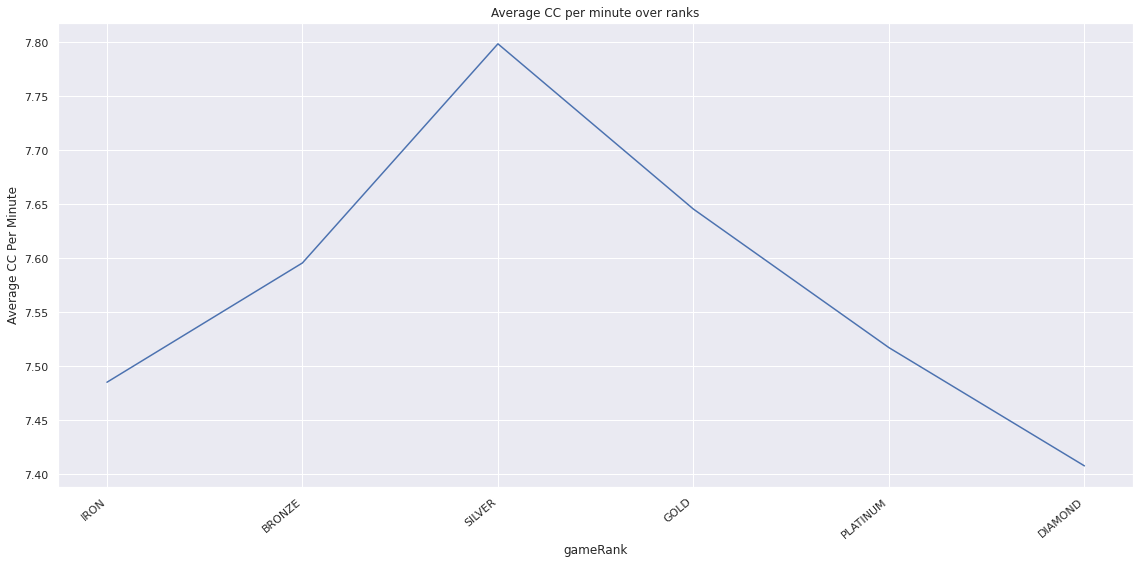

In [358]:
# Get total time CCed in a game and get the time CC'ed divided by minutes
match_df["totalCC"] = match_df["blueTotalCC"] + match_df["redTotalCC"]
match_df["CCRate"] = match_df["totalCC"] / match_df["gameDuration"] * 60

# Get mean CC rate by rank
mean_cc = match_df.groupby("gameRank")["CCRate"].mean()

# Plot mean CC rate by rank
fig, ax = plt.subplots(figsize = (16,8))
ax.set(ylabel='Average CC Per Minute')
plt.title("Average CC per minute over ranks")
ax = sns.lineplot(ax=ax, x=mean_cc.index, y=mean_cc.values)
ax.set_xticklabels(TIERS, rotation=40, ha="right")
plt.tight_layout()
plt.show()

The graph above shows the average total CC per minute over ranks. We add the total time CC'ing (in seconds) for both teams and divide by the number of minutes in the game. From the graph above, we see that the amount of CC peaks at Silver and is low at both ends of the ranked spectrum.

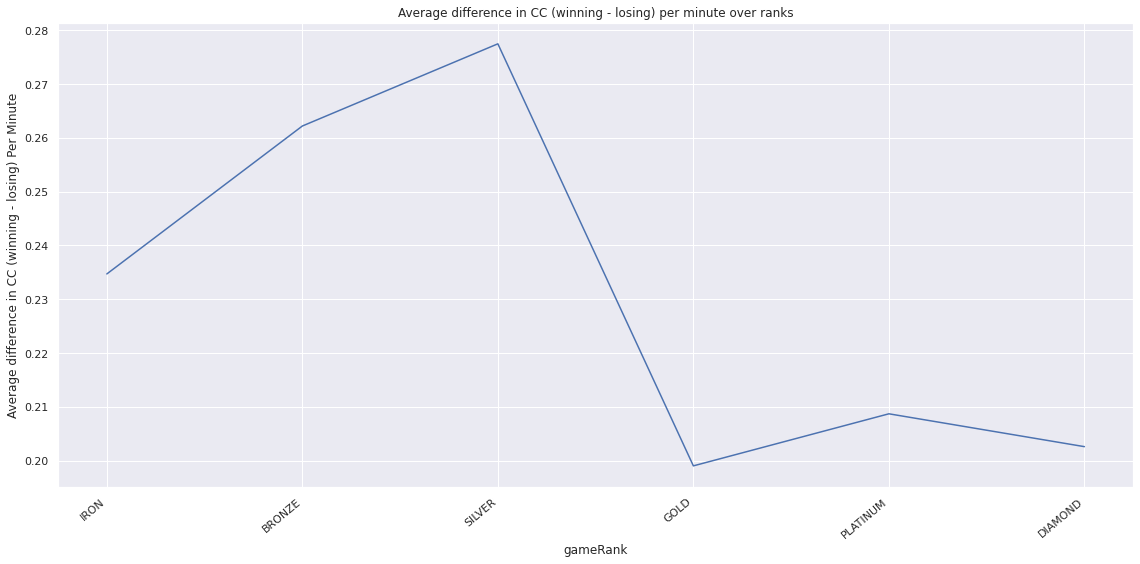

In [359]:
# Get difference in CC per minute and groupby rank
normalized_df["diffTotalCCRate"] = normalized_df["diffTotalCC"] / normalized_df["gameDuration"] * 60
mean_cc = normalized_df.groupby("gameRank")["diffTotalCCRate"].mean()

# Plot mean difference in CC per minute by rank
fig, ax = plt.subplots(figsize = (16,8))
ax.set(ylabel='Average difference in CC (winning - losing) Per Minute')
plt.title("Average difference in CC (winning - losing) per minute over ranks")
ax = sns.lineplot(ax=ax, x=mean_cc.index, y=mean_cc.values)
ax.set_xticklabels(TIERS, rotation=40, ha="right")
plt.tight_layout()
plt.show()

The graph above shows the difference in the amount of CC for the winning team minus the losing team per minute across the ranks. From both graphs, we see that the total amount of CC and the difference in CC both peak at Silver. We can use our game knowledge to reason why this is the case, as lower rank players may be unable to aim abilities well and higher rank players are able to dodge abilities better. 

From the above graph, we also notice that the amount of CC for the winning team minus the losing team is above 0 for all ranks, which indicates that the winning team usually has more CC than the losing team. Similar to what we did in blue side vs red side analysis, we want to see if this difference is statistically significant, so we use a right-tailed two sample T test between the CC of the winning team and CC of the losing team. 

In [360]:
# Get winning CC and losing CC
winning_CC = []
losing_CC = []
for index, row in match_df.iterrows():
  winning_CC.append(row["blueTotalCC"] if row["teamWin"] == "blue" else row["redTotalCC"])
  losing_CC.append(row["blueTotalCC"] if row["teamWin"] == "red" else row["redTotalCC"])

# Right-tailed two sample T test
stats.ttest_ind(winning_CC, losing_CC, equal_var=True, alternative='greater')

Ttest_indResult(statistic=7.558002776441016, pvalue=2.1232215526179488e-14)

Because the p-value is very low and lower than a significance level of 0.05, we can conclude that the true average amount of CC of the winning team has is higher than the true average amount of CC that the losing team has.

What does this tell us? Well, we cannot make an assumption of causation that having more CC abilities/champions causes a team to have a better chance of winning, but we are able to say that the winning team does land more abilities that CC. This makes sense, as landing abilities means good performance and the team that performs better in combat usually wins. 

## Pings

Players use pings to quickly communicate with their team. The ping wheel is shown in the image below. The number of pings made can measure how much players communicate with each other. As a team game, communication is important and can influence wins and losses. We will try to see if there is a relationship between winning, rank, and pings.

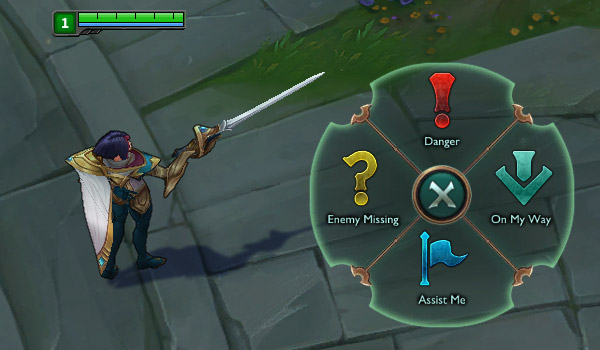


From: https://support-leagueoflegends.riotgames.com/hc/en-us/articles/201752974-Smart-Ping

Half of our data has 0 pings, which may be an issue with Riot's database. We remove these rows for our exploration of pings. Additionally, we must consider that longer games will result in more pings. Thus, we divide the number of pings by minute and get the pings per minute (pingRate) instead of just the number of pings.

Number of matches with 0 pings: 5854


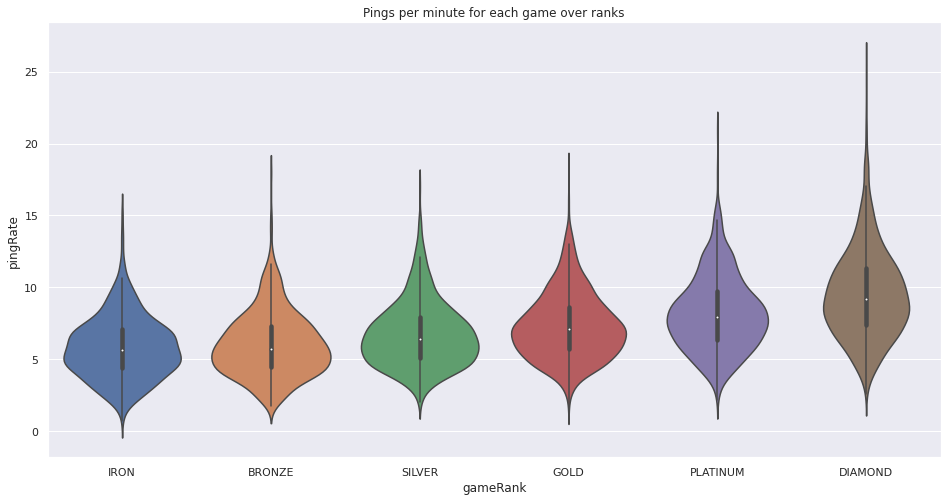

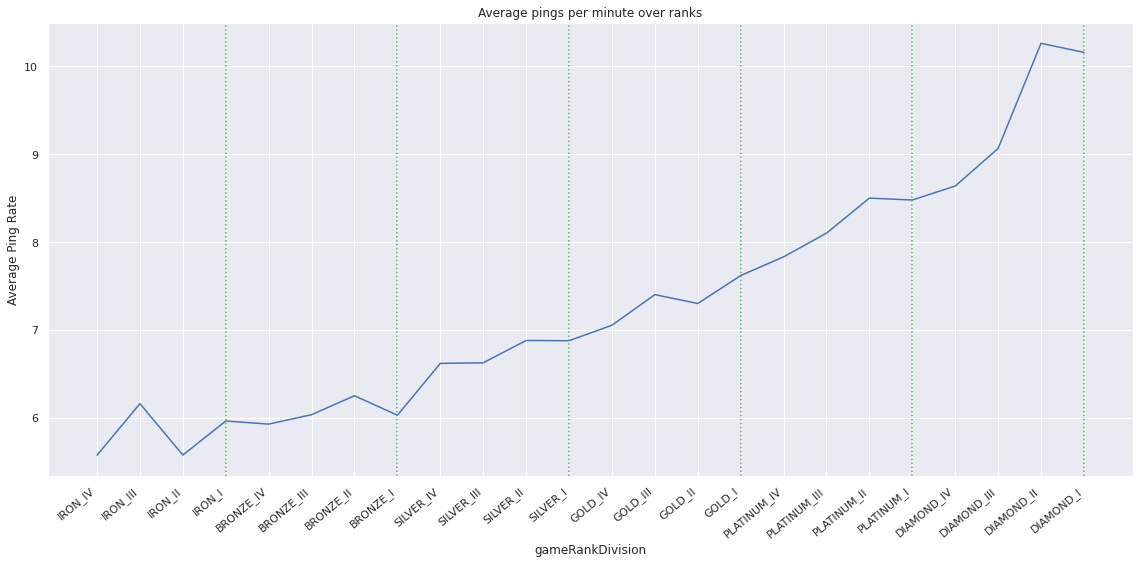

In [361]:
# Calculate total pings 
match_df["totalPings"] = match_df["blueNumPings"] + match_df["redNumPings"]
# Calculate pings per minute
match_df["pingRate"] = match_df["totalPings"] / match_df["gameDuration"] * 60

# Remove rows with 0 pings
print("Number of matches with 0 pings:", len(match_df[match_df["totalPings"] == 0]))
ping_df = match_df[match_df["totalPings"] != 0]

# Make violin plot where x-axis is rank and y-axis is ping rate per game
fig, ax = plt.subplots(figsize = (16,8))
plt.title("Pings per minute for each game over ranks")
ax = sns.violinplot(x=ping_df["gameRank"], y= ping_df["pingRate"])
plt.show()

# Get mean number of pings
mean_pings = ping_df.groupby("gameRankDivision")["pingRate"].mean()

# Plot line graph of mean pings per game across ranks
fig, ax = plt.subplots(figsize = (16,8))
ax.set(ylabel='Average Ping Rate')
plt.title("Average pings per minute over ranks")
ax = sns.lineplot(ax=ax, x=mean_pings.index, y=mean_pings.values)
ax.set_xticklabels(RANKED_ORDER, rotation=40, ha="right")
plt.tight_layout()
for tier in TIERS:
  plt.axvline(x = tier + "_I", color = 'g', linestyle = "dotted")
plt.show()

The first graph above is a violin plot of the number of pings per minute for each game over the ranks. The mean of the number of pings seems to increase as you go from lower rank to higher rank. The second graph shows the mean number of pings per minute over each rank and division. We see that the mean significantly increases across the ranks. From these graphs, it appears that higher ranked players use more pings.

Number of matches with diff pings at 0: 5895


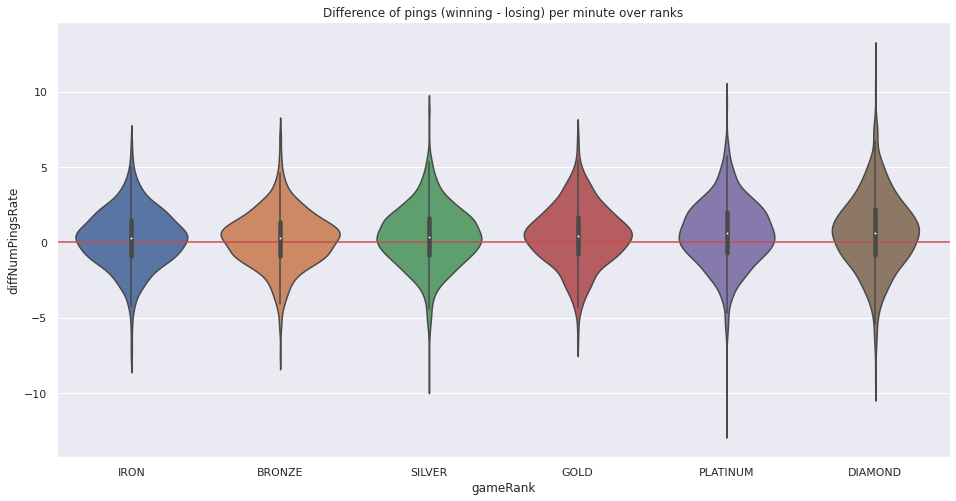

gameRank
IRON        0.250514
BRONZE      0.230478
SILVER      0.369181
GOLD        0.437399
PLATINUM    0.615528
DIAMOND     0.675831
Name: diffNumPingsRate, dtype: float64

In [362]:
# Remove games with diffNumPings = 0
print("Number of matches with diff pings at 0:", len(normalized_df[normalized_df["diffNumPings"] == 0]))
ping_df = normalized_df[normalized_df["diffNumPings"] != 0]

# Make difference in pings per minute
ping_df["diffNumPingsRate"] = (ping_df["diffNumPings"] / ping_df["gameDuration"]) * 60

# Create violin plot of difference in pings (winning team minus losing team) per minute over the ranks
fig, ax = plt.subplots(figsize = (16,8))
plt.axhline(y = 0, color = 'r', linestyle = '-')
ax.set(xlabel='Rank', ylabel='Difference in Pings')
plt.title("Difference of pings (winning - losing) per minute over ranks")
ax = sns.violinplot(x=ping_df["gameRank"], y= ping_df["diffNumPingsRate"])
plt.show()

# Print out means
ping_df.groupby("gameRank")["diffNumPingsRate"].mean()

The graph above is a violin plot of the difference of pings per minute over the ranks. This value is calculated by subtracting the number of pings of the losing team from the number of pings from the winning team and dividing by minutes. A value above 0 indicates that the winning team had more pings than the losing team, and a value below 0 indicates that the losing team had more pings than the winning team. Although very slight, the means are all above 0 and increases across the ranks. Thus, the winning team usually makes more pings and thus communicates more.

This finding is quite surprising to us, as we thought that the amount of communication would be around the same in both teams. In fact, we thought that the losing team might have more pings, as the losing team might ping to insult each other or start to coordinate more and try to make a play that overturns the game. 

## Vision

In League of Legends, players can only see parts of the map around ally champions, minions, and structures while the rest is hidden in the fog of war. However, players have the ability to buy and place down wards that grant vision around them. There are many kinds of wards and ways of discovering and destroying wards. 

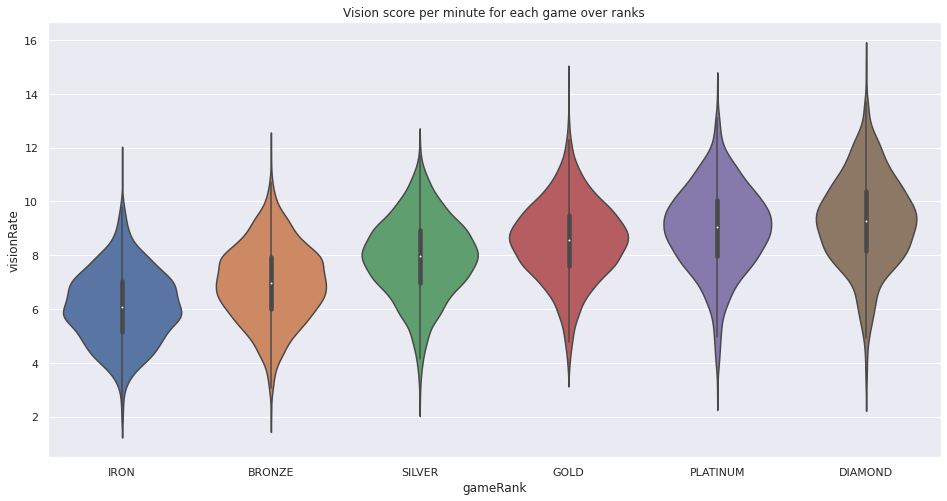

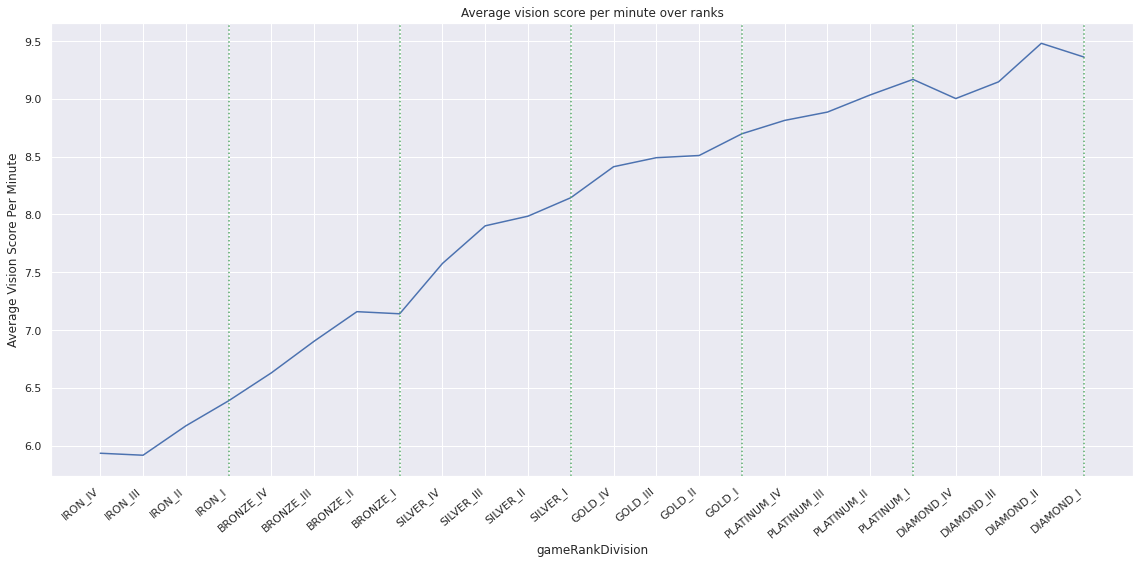

In [363]:
# Calculate total vision score 
match_df["totalVision"] = match_df["blueTotalVisionScore"] + match_df["redTotalVisionScore"]
# Calculate vision score per minute
match_df["visionRate"] = match_df["totalVision"] / match_df["gameDuration"] * 60

# Make violin plot where x-axis is rank and y-axis is vision score rate per game
fig, ax = plt.subplots(figsize = (16,8))
plt.title("Vision score per minute for each game over ranks")
ax = sns.violinplot(x=match_df["gameRank"], y= match_df["visionRate"])
plt.show()

# Get mean vision score grouped by ranks
mean_vision = match_df.groupby("gameRankDivision")["visionRate"].mean()

# Plot line graph of mean vision per game across ranks
fig, ax = plt.subplots(figsize = (16,8))
ax.set(ylabel='Average Vision Score Per Minute')
plt.title("Average vision score per minute over ranks")
ax = sns.lineplot(ax=ax, x=mean_vision.index, y=mean_vision.values)
ax.set_xticklabels(RANKED_ORDER, rotation=40, ha="right")
plt.tight_layout()
for tier in TIERS:
  plt.axvline(x = tier + "_I", color = 'g', linestyle = "dotted")
plt.show()

The first graph is a violin plot of the vision score per minute over the ranks. The second graph is a line graph of the average vision score per minute over the ranks. From these graphs, we see that the amount of vision very substantially increases across the ranks and even across divisions within a tier, even though the trend starts to become less clear in Diamond.

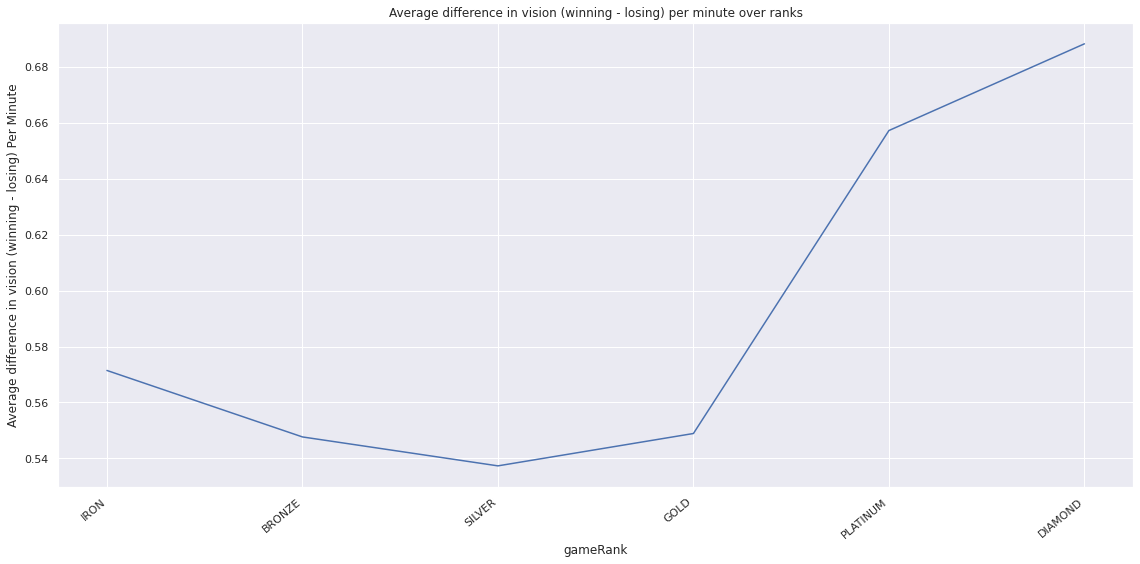

In [364]:
# Get difference in vision per minute and group by rank
normalized_df["diffTotalVisionScoreRate"] = normalized_df["diffTotalVisionScore"] / normalized_df["gameDuration"] * 60
mean_vision = normalized_df.groupby("gameRank")["diffTotalVisionScoreRate"].mean()

# Plot mean difference in CC per minute by rank
fig, ax = plt.subplots(figsize = (16,8))
ax.set(ylabel='Average difference in vision (winning - losing) Per Minute')
plt.title("Average difference in vision (winning - losing) per minute over ranks")
ax = sns.lineplot(ax=ax, x=mean_vision.index, y=mean_vision.values)
ax.set_xticklabels(TIERS, rotation=40, ha="right")
plt.tight_layout()
plt.show()

The graph above shows the difference in the vision score for the winning team minus the losing team per minute across the ranks. It's interesting to see that the difference in vision actually decreases from Iron to Silver, slightly increases at Gold, and then overwhelmingly increases in Platinum and Diamond. Perhaps Platinum and Diamond players are able to utilize vision much better than lower ranked players.

We also notice that the mean difference in vision score per minute is also always above 0, which indicates that the wining team usually has a higher vision score than the losing team. 

## Objectives

Objectives in League of Legends are certain things that a team can obtain to help them win the game. They include killing the neutral monsters Rift Herald, Baron Nashor, and dragons, as well as structures like towers and inhibitors. In our analysis, we will count player kills as objectives too because we want to compare the influence of kills with the influence of other objectives. Below we list a quick summary of what each objective does.

*   Rift Herald - An early game monster that spawns in the Baron pit before 
*   Baron Nashor - A late game monster that grants all living teammates a 180 second buff that gives bonus attack damage and ability power, and an aura that greatly empowers nearby minions.
*   Dragons - A type of monster that spawns throughout the game and grants a permanent buff to all players on the team. The team that obtains 4 dragons will get the dragon soul, which gives another permanent buff to all players on the team. After the dragon soul is obtained, elder dragons will spawn which grant a 150 second buff to all living teammates that helps obtain kills on enemy players.
*   Towers - Teams must destroy enemy towers to push their assault into enemy territory.
*   Inhibitors - Once a team destroys an enemy inhibitor, super minions are spawned in the respective lane, which help to push further into an enemy's base.
*   Kills - After a player is killed, they must wait for a duration (death timer) before respawning.



We want to see the influence of objectives on winning. Although typically you wouldn't use a regression to predict the value of a categorical variable (win or loss), we want to see how much different objectives factor in to how likely a team is to win. 

So, we will treat win/loss as a continuous variable, where 1 means blue wins, -1 means blue loses, and 0 means the team that wins at the end will be a tossup. For example, a low positive value means that the model slightly thinks blue will win, whereas a high positive value means that the model thinks blue will definitely win. The same can be said about red, which would be negative values.

From https://stattrek.com/multiple-regression/interaction, "In regression, an interaction effect exists when the effect of an independent variable on a dependent variable changes, depending on the value(s) of one or more other independent variables." This sounds exactly like what happens with game duration and every other variable. Impact of fields such as dragon differential changes depending on the length of the game. Having one extra dragon at 15 minutes is more of a "stomp" (overwhelming win) than having one extra dragon 35 minutes into the game.

Here, we use the normalized dataframe in perspective of blue team and change the teamWin column so that blue winning is 1 and red winning is -1.

In [365]:
# Normalize teamWin from 0 to 1 -> -1 to 1
regression_df = blue_side_df.copy()
regression_df["standardizedTeamWin"] = list(map(lambda teamWin: 1 if teamWin == 1 else -1, regression_df["teamWin"]))
regression_df.head()

,teamWin,gameRankDivision,gameRank,gameDivision,gameDuration,diffFirstBaron,diffNumBaron,diffFirstBlood,diffNumKills,diffFirstDragon,...,diffNumTower,diffNumPings,diffNumAssists,diffTotalExp,diffTotalGold,diffTotalCC,diffTotalDamage,diffTotalCS,diffTotalVisionScore,standardizedTeamWin
0,1,IRON_IV,IRON,IV,2103,1,1,1,21,0,...,7,-133,4,1034,8430,171,14534,0,-53,1
1,1,IRON_IV,IRON,IV,1688,1,1,0,8,1,...,4,23,-5,13894,7649,-1,13638,-21,-47,1
2,0,IRON_IV,IRON,IV,1465,0,0,0,-4,0,...,-11,2,-10,-9805,-13633,-23,-15673,-242,-41,-1
3,1,IRON_IV,IRON,IV,963,0,0,1,13,1,...,3,36,9,6034,9783,-5,12810,58,18,1
4,0,IRON_IV,IRON,IV,2014,0,-2,1,-18,0,...,-4,51,-8,-4963,-9776,62,-18737,-81,-9,-1


When looking at objectives, we only look at the number of objectives taken to simplify our analysis. We create our linear regression formula with interaction terms between all the objectives and the game duration.

In [366]:
# Linear regression formula
formula = "standardizedTeamWin ~ "\
            "gameDuration:diffNumBaron + "\
             "gameDuration:diffNumKills + "\
             "gameDuration:diffNumDragon + "\
             "gameDuration:diffNumInhibitor + "\
             "gameDuration:diffNumRiftHerald + "\
             "gameDuration:diffNumTower"
linreg = ols(formula=formula, data=regression_df).fit()

print(linreg.summary())

                             OLS Regression Results                            
Dep. Variable:     standardizedTeamWin   R-squared:                       0.802
Model:                             OLS   Adj. R-squared:                  0.802
Method:                  Least Squares   F-statistic:                     7727.
Date:                 Wed, 14 Dec 2022   Prob (F-statistic):               0.00
Time:                         06:17:20   Log-Likelihood:                -6974.4
No. Observations:                11454   AIC:                         1.396e+04
Df Residuals:                    11447   BIC:                         1.401e+04
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
In

As we can see, the F-statistic is ~7727, with a very low p-value. Thus, the influence of objectives on the probability of winning is very high, as one might expect.



Let's view some sample coefficient values if we set the game duration to 30 minutes.

In [367]:
# Coefficient values at 30 minutes
print(linreg.params.apply(lambda x: x*1800))

Intercept                         12.429337
gameDuration:diffNumBaron          0.035018
gameDuration:diffNumKills          0.020241
gameDuration:diffNumDragon         0.020349
gameDuration:diffNumInhibitor     -0.044492
gameDuration:diffNumRiftHerald    -0.011209
gameDuration:diffNumTower          0.112458
dtype: float64


As you can see, some of the coefficients of our features are negative. There are two possible interpretations to negative coefficients: a negative coefficient means that either the corresponding feature becomes less important as the games get longer in duration, or obtaining the corresponding objective is actually detrimental to a team's success. We are inclined to go with the former explanation because all objectives are designed to help the team win. The objectives with negative coefficients, the number of inhibitors and Rift Heralds gained, can be explained with some game knowledge. These two objectives definitely seem to have less impact as the game gets longer. Rift Herald is an early game objective, that usually gets a tower for the team, and it does not give a permanent buff. Getting an inhibitor early is a sign that a team is stomping very hard and is thus more likely to win the game, since inhibitors are inside the base and you need to get all the towers in a lane before you can get the inhibitor. However, the longer a game drags on with inhibitors taken, the more gold you are giving the enemy team because of super minions, so, getting inhibitors early on is actually detrimental.

It seems that the most important objective to get is towers. This makes sense, as destroying towers is the only way to get deeper into an enemy's base, and thus destroy the nexus and winning the game.

We are curious if certain objectives matter more in higher ranks because players are able to utilize their benefits better.

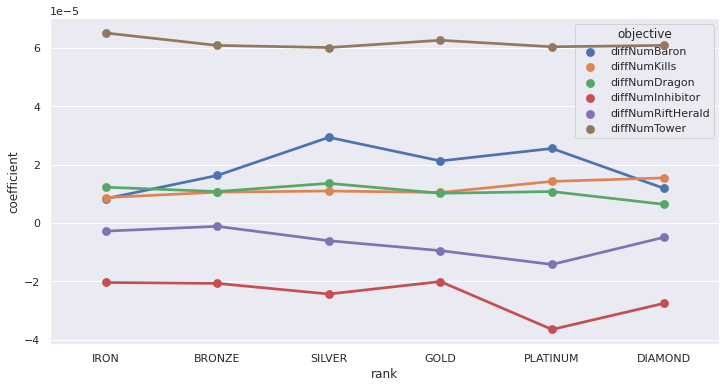

In [368]:
coefficient_data = {
    "rank": [],
    "objective": [],
    "coefficient": []
}

# Groups by rank and makes regression for each rank
for name, group in regression_df.groupby("gameRank"):
  linreg = ols(formula=formula, data=group).fit()
  for objective, coef in linreg.params.items():
    if objective == "Intercept":
      continue
    objective = objective.split(":")[1]
    coefficient_data["rank"].append(name)
    coefficient_data["objective"].append(objective)
    coefficient_data["coefficient"].append(coef)
      

# Make df from coefficient data
coefficient_df = pd.DataFrame.from_dict(coefficient_data)

# Graph coefficients
sns.set(rc={'figure.figsize':(12, 6)})
sns.pointplot(data=coefficient_df, x="rank", y="coefficient", hue="objective")

The graph above shows how the coefficient of each objective changes across the ranks. From this graph, we can see that the influence of most objectives is not affected by ranks. The only objective that might have a trend with rank is player kills, as its coefficient seems to slightly increase across the ranks. This indicates that after obtaining a kill, higher ranked players are able to better utilize this advantage to further their advantage. 

## Farming

In League of Legends, gold is very important because you use gold to buy items in the shop that can make your champion get stronger. Experience is also important because your champion gets stronger as you level up. The primary method for players to get gold and experience is through farming, which is killing non-player mobs (minions, jungle camps). Your creep score (CS) counts how many minions/camps you've killed, and essentially is your farm score. 

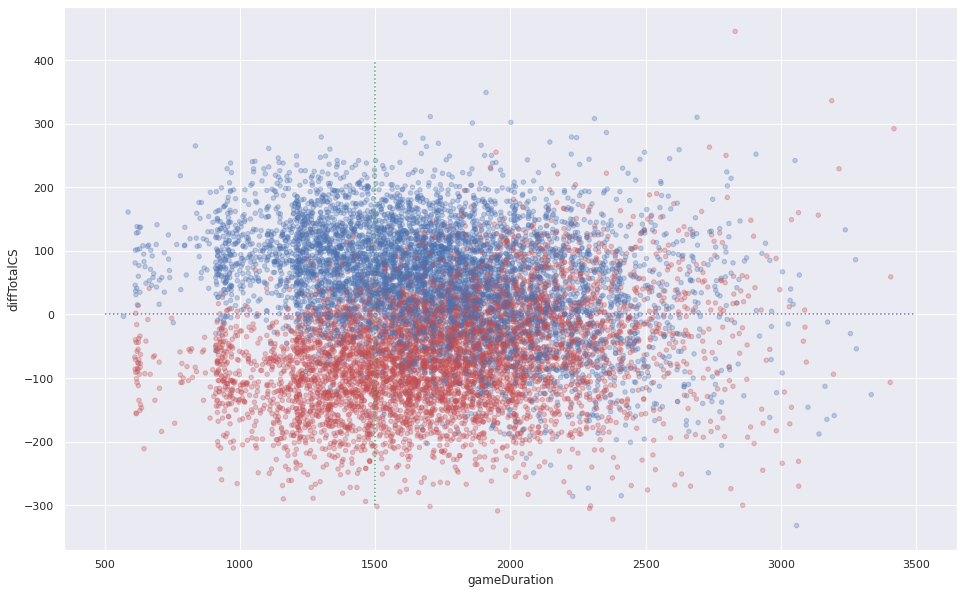

In [369]:
# Make scatter plot of CS and time
blue_side_df.plot.scatter(x='gameDuration',
                       y='diffTotalCS',
                       alpha=.3,
                       figsize=(16,10),
                       c=blue_side_df.teamWin.map({1: "b", 0: "r"}))

plt.plot([500, 3500], [0, 0], color='m', linestyle='dotted', linewidth=1.5, alpha=1)
plt.plot([1500, 1500], [-300, 400], color='g', linestyle='dotted', linewidth=1.5, alpha=1)

The scatter plot above shows the difference in CS (blue - red) for each game over the duration of the game. A point above 0 means that the blue team had more CS and a point below 0 means that the red team had more CS. The color of each point indicates the team that won. 

Before 1500 seconds (25 minutes), having more CS than the other team seems to be a very clear sign of which team will win, while the trend seems to diverge pretty heavily after 1500 seconds. Thus, we think that we should treat these two sections of the game differently in further analysis. 

An interesting metric to analyze in this section is the "predictability" of a match with respect to the CS differential - if a team has a positive CS differential, how likely are they to win at different stages of the game? We will calculate "predictability" by taking the proportion of games that are "properly" placed with regards to the CS differential: a blue win with a positive CS differential is properly placed, a red win with a positive CS differential is improper, a blue win with a negative CS differential is improper, and a red win with a negative CS differential is proper.

We bin games by every 5 minutes for this calculation.

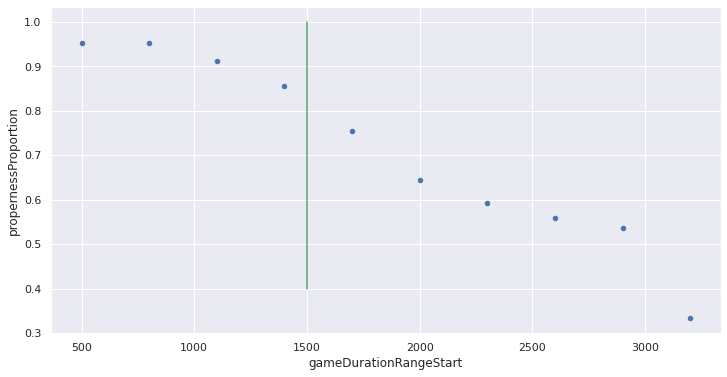

In [370]:
# Given a match, determine if it is proper according to the 
# team that won and the cs differential.
def label_properness(row):
  # If blue won, the game is proper if the cs differential was positive
  if row["teamWin"] == 1 and row["diffTotalCS"] > 0:
    return True
  # If red won, the game is only proper if cs differential was negative
  if row["teamWin"] == 0 and row["diffTotalCS"] < 0:
    return True
  # otherwise, the game is improper
  return False


# We make a new df containing "properness" - whether or not the game is proper
# according to the team win and cs differential.
properness_df = blue_side_df[["gameDuration", "gameRank"]]
properness_df["properness"] = blue_side_df.apply(label_properness, axis=1)
# Note the longest game is ~3500 seconds long. binning by every 5 minute, every 300 secs
RANGE = 300
# Properness proportion is the proportion of games in the given time range are proper
properness_proportions_data = {
    "gameDurationRangeStart": [],
    "propernessProportion": []
}
for start_time in range(500, 3500, RANGE):
  end_time = start_time + (RANGE - 1)
  # Get all games in the given time range
  time_range = properness_df[properness_df["gameDuration"].between(start_time, end_time, inclusive="both")]

  properness_proportions_data["gameDurationRangeStart"].append(start_time)
  # Calculate the proportion of proper games in this time range
  prop_proportion = np.nan if len(time_range) == 0 else len(time_range[time_range["properness"]]) / len(time_range)
  properness_proportions_data["propernessProportion"].append(prop_proportion)

properness_proportions_df = pd.DataFrame.from_dict(properness_proportions_data)
# Make scatter plot of these proportions
properness_proportions_df.plot.scatter(x="gameDurationRangeStart", y="propernessProportion")
plt.plot([1500, 1500], [.4, 1], color='g', linewidth=1.5, alpha=1)


The graph above shows the proportion of games that are marked as "proper" in that game duration bin. As we might expect, the predictability of games decreases as game duration increases when we are only looking at CS differential. We are curious to see how does the CS data compares across ranks.

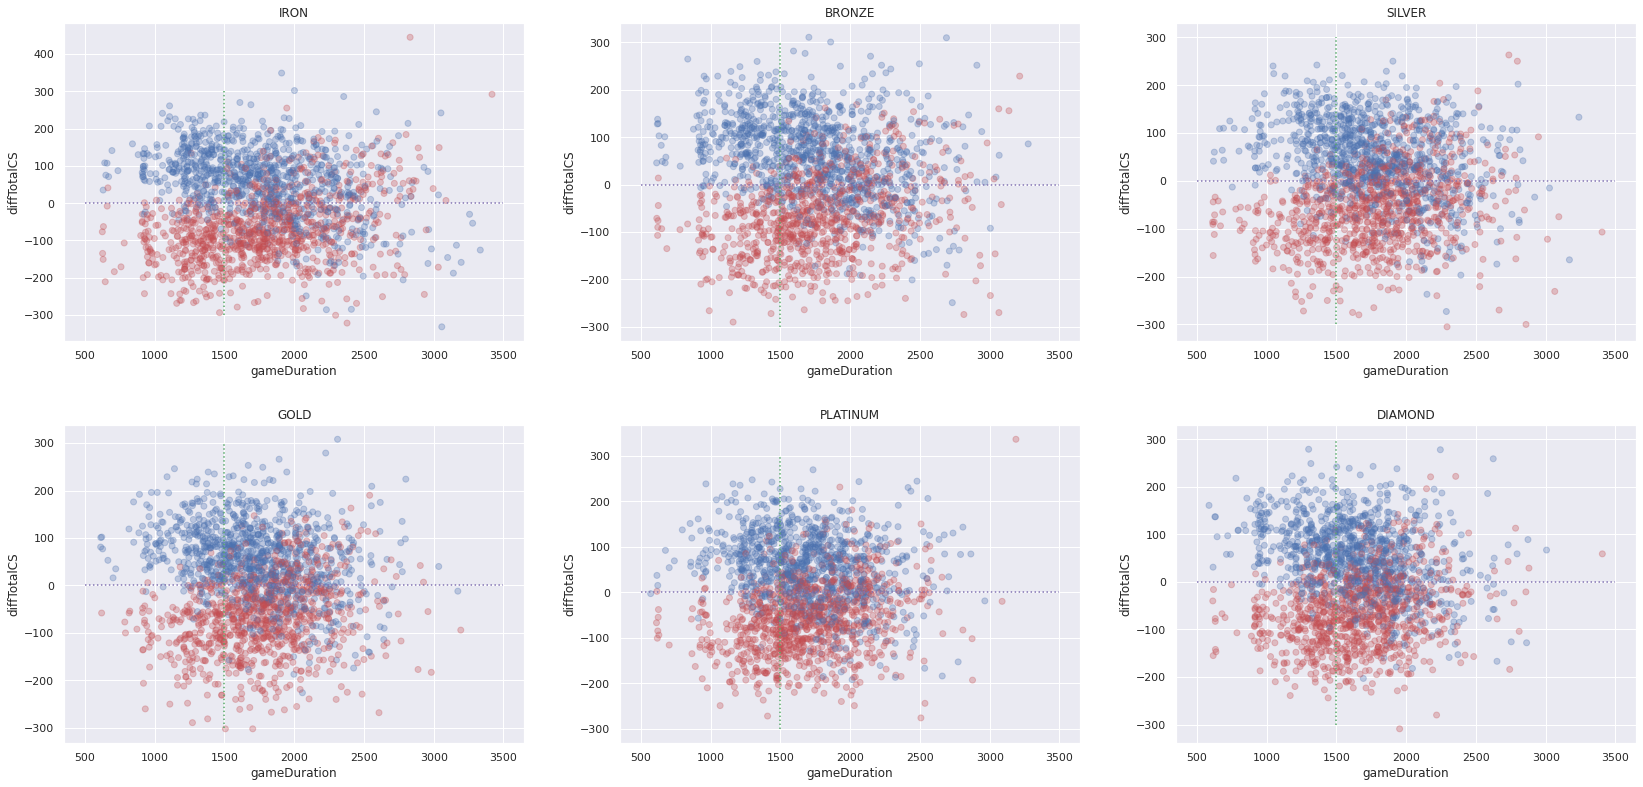

In [371]:
# Sort by rank
def sort_ranks(rank):
  tier = rank[0]
  return TIERS.index(tier)

# Grid of plots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(24, 12))
fig.tight_layout(pad=5.0)

# Iterate through data grouped by game rank
i = 0
for name, group in sorted(list(blue_side_df.groupby("gameRank")), key=sort_ranks):
  # Scatter Plot CS and time
  curr_plot = axs[i // 3, i % 3]
  curr_plot.scatter(x='gameDuration',
                    y='diffTotalCS',
                    data=group,
                    c=group.teamWin.map({1: "b", 0: "r"}),
                    alpha=.3)
  curr_plot.set_title(name)
  curr_plot.set_xlabel("gameDuration")
  curr_plot.set_ylabel("diffTotalCS")
  curr_plot.plot([500, 3500], [0, 0], color='m', linestyle='dotted', linewidth=1.5, alpha=1)
  curr_plot.plot([1500, 1500], [-300, 300], color='g', linestyle='dotted', linewidth=1.5, alpha=1)
  i += 1

Visually, there is not much of a difference between all of the ranks, but how different is the properness of games depending on rank? We use the same metrics for "properness" as before, which is the proportion of games marked as proper in that time bin. 

We stop the game duration at 2500 because there is not a lot of data after 2500.

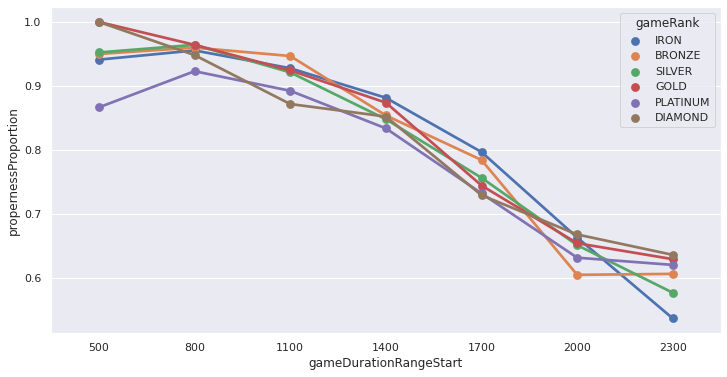

In [372]:
RANGE = 300
properness_proportions_rank_data = {
    "gameDurationRangeStart": [],
    "propernessProportion": [],
    "gameRank": []
}

# Iterate through data grouped by game rank
for name, group in properness_df.groupby("gameRank"):
  # Bin by time
  for start_time in range(500, 2500, RANGE):
    end_time = start_time + (RANGE - 1)
    time_range = group[group["gameDuration"].between(start_time, end_time, inclusive="both")]

    # Store data of game duration, properness proportion, and rank
    properness_proportions_rank_data["gameDurationRangeStart"].append(start_time)
    properness_proportions_rank_data["propernessProportion"].append(
        np.nan if len(time_range) == 0 else len(time_range[time_range["properness"]]) / len(time_range)
      )
    properness_proportions_rank_data["gameRank"].append(name)

# Convert to data frame and plot
properness_proportions_rank_df = pd.DataFrame.from_dict(properness_proportions_rank_data)
sns.pointplot(data=properness_proportions_rank_df, x="gameDurationRangeStart", y="propernessProportion", hue="gameRank")


Unfortunately, it looks like there is not much of a discernable trend. Maybe we can sort of see that Platinum and Diamond games are less proper in the earlier time ranges, while they are more proper in the later time ranges, but it's really not that big of a difference.

Lastly, let's compare CS over the ranks to see if there is a trend.

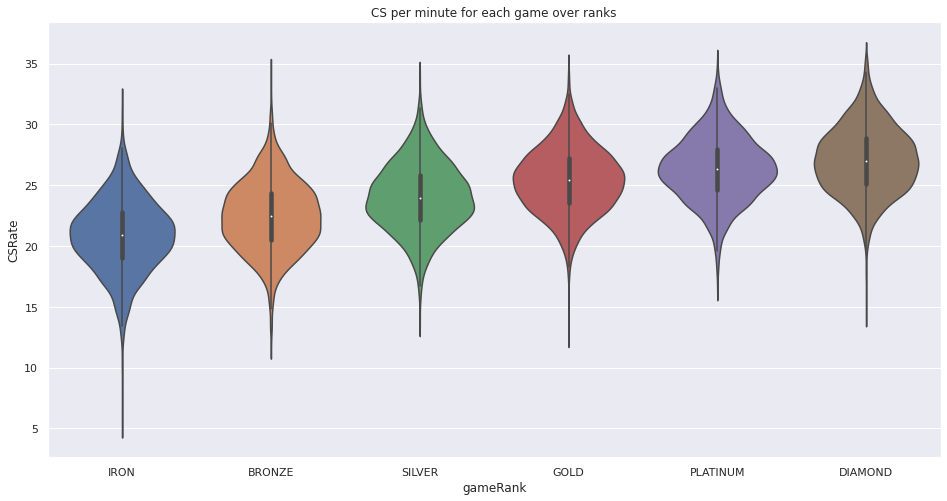

In [373]:
# Calculate total CS 
match_df["totalCS"] = match_df["blueTotalCS"] + match_df["redTotalCS"]
# Calculate CS per minute
match_df["CSRate"] = match_df["blueTotalCS"] / match_df["gameDuration"] * 60

# There are no games with 0 CS, no missing data
# print("Number of matches with 0 pings:", len(match_df[match_df["totalCS"] == 0]))

# Make violin plot where x-axis is rank and y-axis is CS rate per game
fig, ax = plt.subplots(figsize = (16,8))
plt.title("CS per minute for each game over ranks")
ax = sns.violinplot(x=match_df["gameRank"], y= match_df["CSRate"])
plt.show()

The graph above shows the total CS per minute for each game over the ranks. We see a trend that the CS per minute increases as rank increases, which indicates that higher ranked players farm better. 

## Tying it Together

We want to try and make a classifier that will be able to predict the outcome of a game (whether blue or red won) using the factors we explored above: side, crowd control, pings, vision, objectives, and farming. 

We use the normalized dataframe in reference to the blue side so that a negative value in any difference column means that red side had more of it and positive value means that blue side had more of it. Note that the gameWin column is our target, and 0 means red won while 1 means blue won.

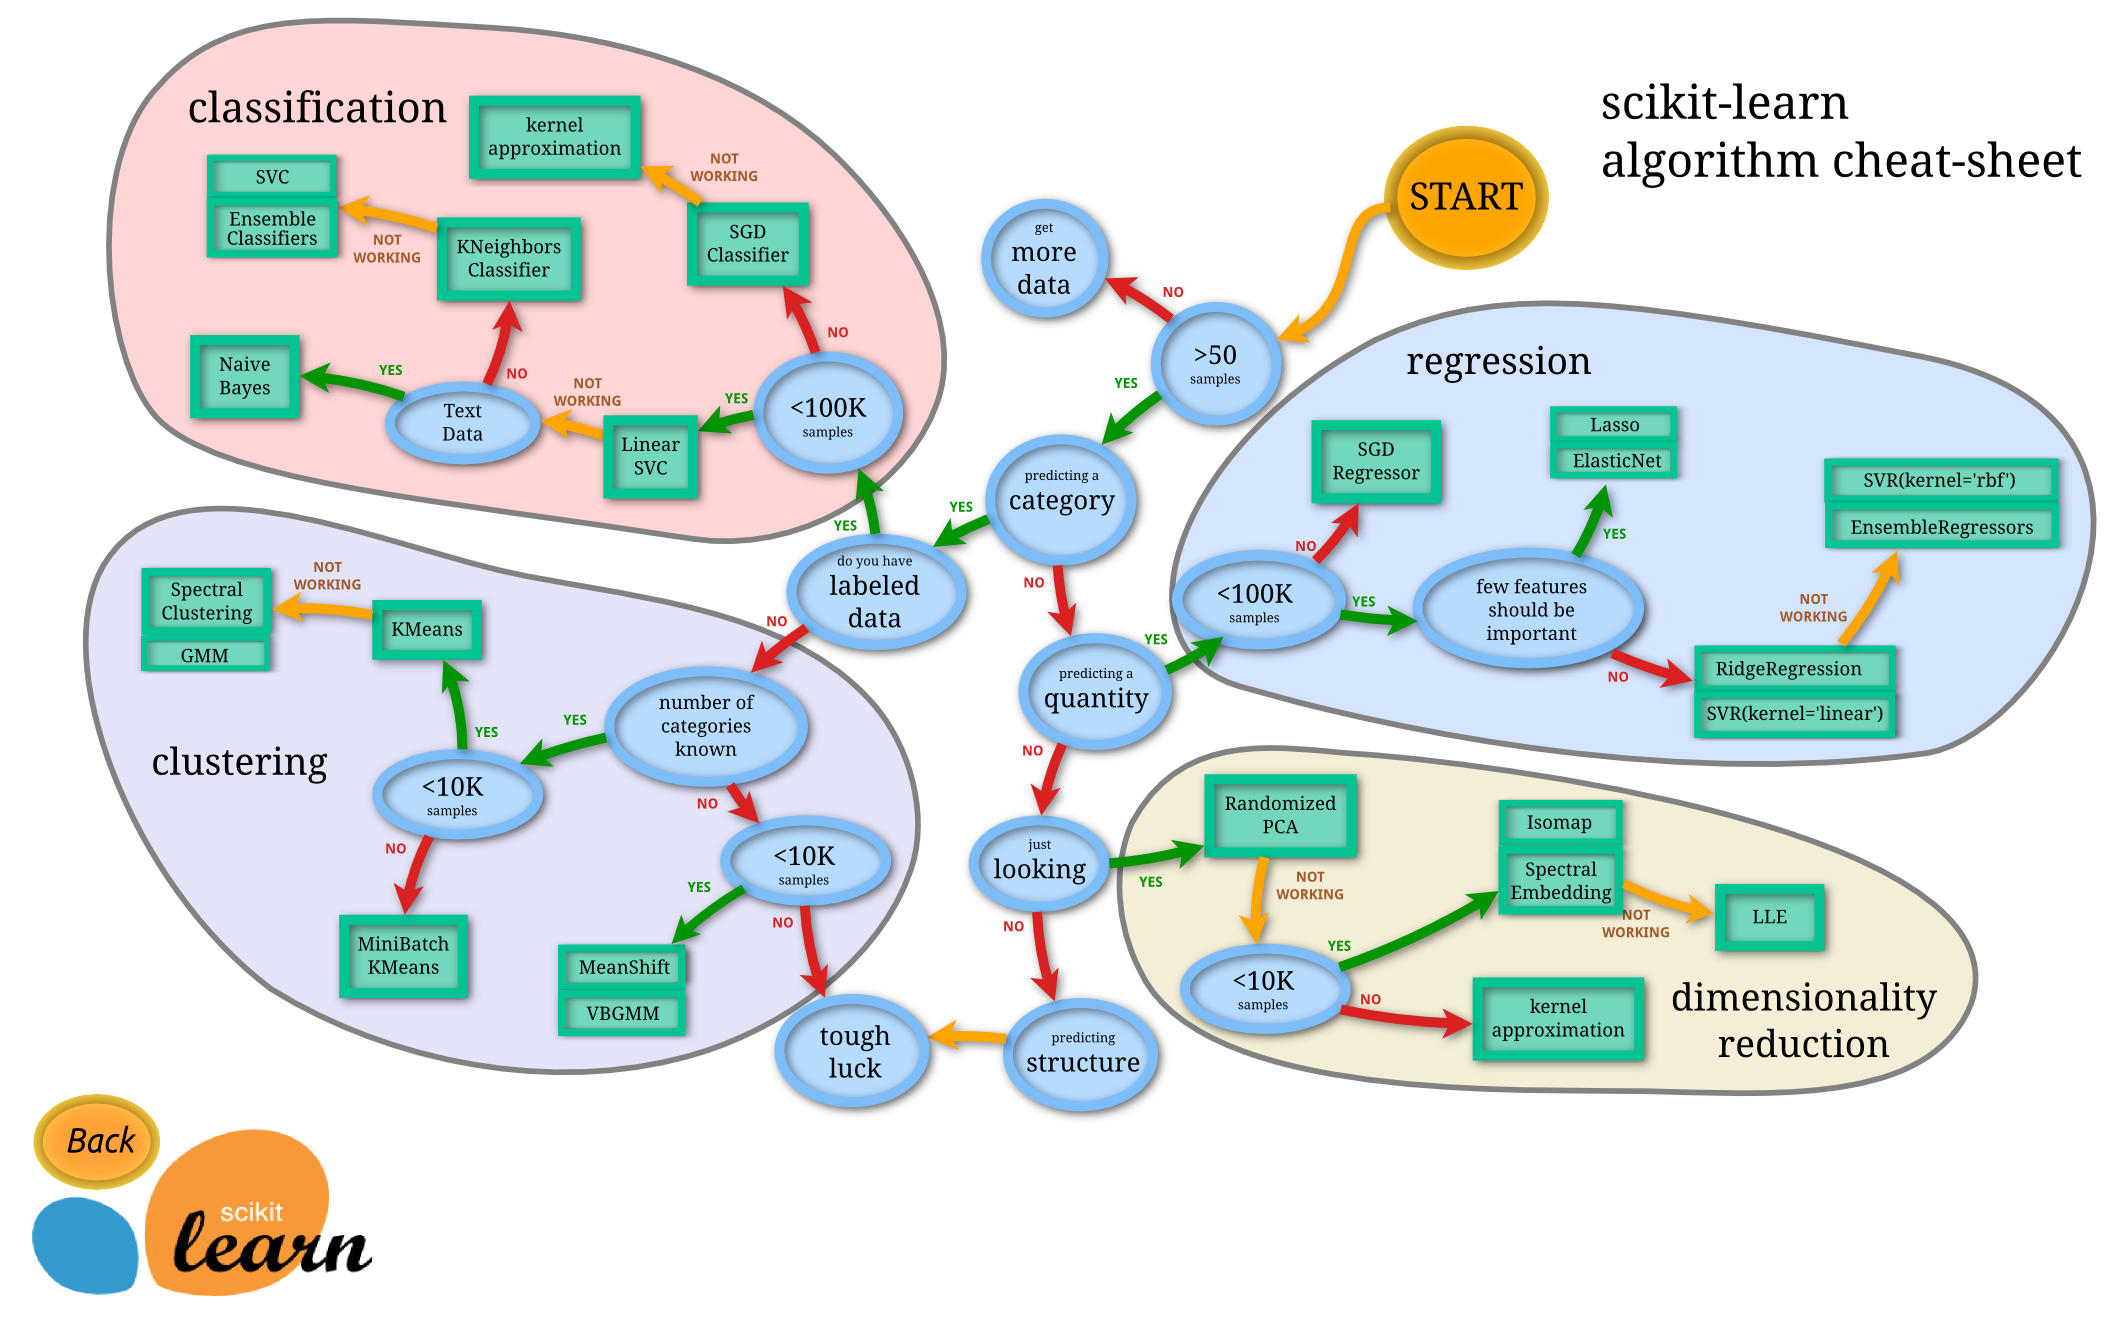
From: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

From the graphic above, we choose a Linear SVC because we want to classify between the two categories blue or red win, we have labeled data, and we have less than 100K samples.

For the hyperparameters, we set dual to False because sklearn documentation tells us that dual=False is prefered when the number of samples is greater than the number of features, which is true in this case. We also set fit_intercept to True because we know from earlier analysis that the map is biased towards blue winning, so we are okay with there being an intercept. We also tried different C values, but the results were not very significant, so we decided to use the default value. This article https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769 explains more about choosing hyperparameters.

To test our classifier, we use holdout validation by splitting the dataset so that 70% would be for training and 30% would be for testing. 

In [374]:
# Create dependent and independent variables
feature_names = ["diffNumBaron", "diffNumKills", 
                  "diffNumDragon", "diffNumInhibitor", "diffNumRiftHerald", 
                  "diffNumTower", "diffNumPings", "diffTotalCC", "diffTotalCS",
                  "diffTotalVisionScore"]
X = blue_side_df[feature_names] 
Y = blue_side_df["teamWin"]

# Split data into 70% training data, 30% testing data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)


# Linear SVC 
svc = LinearSVC(dual=False, fit_intercept=True)
svc.fit(X_train, y_train)

# Print test accuracy
y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred, average='macro'))
print("Recall:", metrics.recall_score(y_test, y_pred, average='macro'))

# Print coefficients
print("\nCoefficients")
coefs = svc.coef_.tolist()[0]
coefs, feature_names = zip(*sorted(zip(coefs, feature_names)))
feature_names = list(feature_names)
for i in range(len(feature_names)):
  print(feature_names[i], coefs[i])

sample_pred = svc.predict([[0,0,0,0,0,0,0,0,0,0]])
print("\nDefault win: ", sample_pred)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1692
           1       0.98      0.98      0.98      1745

    accuracy                           0.98      3437
   macro avg       0.98      0.98      0.98      3437
weighted avg       0.98      0.98      0.98      3437

Accuracy: 0.9764329356997381
Precision: 0.9764110431525546
Recall: 0.9764497686737521

Coefficients
diffNumRiftHerald -0.06628477897589402
diffTotalVisionScore -0.002485475509600148
diffTotalCC 0.0005157204380075074
diffNumPings 0.00130219428220485
diffTotalCS 0.0019509476615675674
diffNumInhibitor 0.03052668204148877
diffNumDragon 0.04148535470694263
diffNumKills 0.04940501088172029
diffNumBaron 0.11635075603246103
diffNumTower 0.2560004382780566

Default win:  [1]


Wow, our accuracy is not bad! Let us see what the coefficients tell us. The greater the value, the more weight the feature has. Above, we sort the coefficients from least to greatest, so this list tells us how much value each factor has towards winning a game Here is the list of what matters the most in winning a game from greatest to least: towers, barons, kills, dragons, inhibitors, pings, CS, CC, Vision, and Rift Herald. Towers being the most important supports what we discovered earlier in the Objectives section. We create a sample prediction where we set all of our features to 0 and see that the classifier gave a result of 1, meaning blue side winning. This supports our earlier evidence that the map is biased and blue side is more likely to win.

Now, we want to see if the influence changes across ranks because there is a substantial difference between lower and higher ranks. Let's create a model for each rank and compare the accuracy and coefficients.

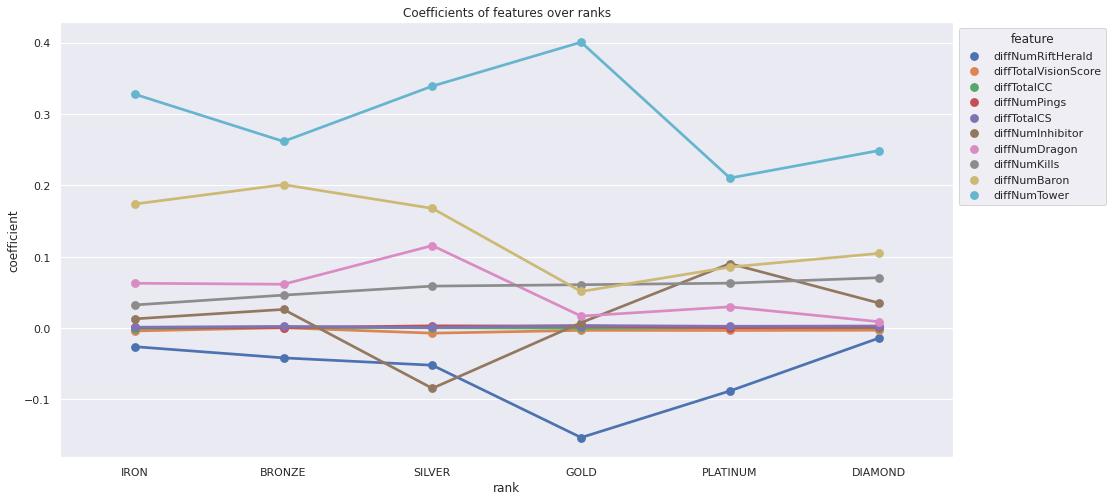

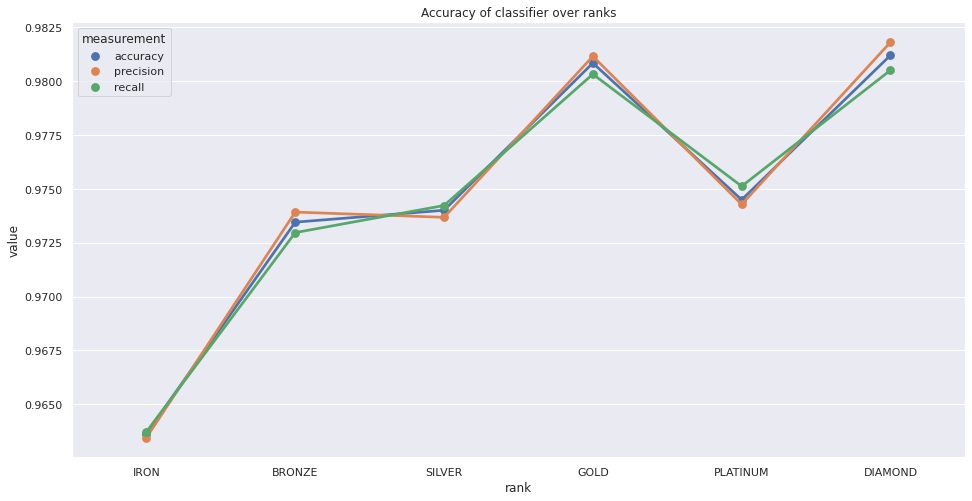

In [385]:
coefficient_data = {
    "rank": [],
    "feature": [],
    "coefficient": [],
}

accuracy_data = {
    "rank": [],
    "measurement" : [],
    "value" : []
}

# Iterate through ranks
for tier in TIERS:
  rank_df = blue_side_df[blue_side_df["gameRank"] == tier]
  X = rank_df[feature_names] 
  Y = rank_df["teamWin"]

  # Split data into 70% training data, 30% testing data
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

  # Linear SVC 
  svc = LinearSVC(dual=False, fit_intercept=True)
  svc.fit(X_train, y_train)

  # Store accuracy data
  y_pred = svc.predict(X_test)
  accuracy_data["rank"].extend([tier] * 3)
  accuracy_data["measurement"].append("accuracy")
  accuracy_data["measurement"].append("precision")
  accuracy_data["measurement"].append("recall")
  accuracy_data["value"].append(metrics.accuracy_score(y_test, y_pred))
  accuracy_data["value"].append(metrics.precision_score(y_test, y_pred, average='macro'))
  accuracy_data["value"].append(metrics.recall_score(y_test, y_pred, average='macro'))

  # Store coefficient data 
  coefs = svc.coef_.tolist()[0]
  for i in range(len(feature_names)):
    coefficient_data["rank"].append(tier)
    coefficient_data["feature"].append(feature_names[i])
    coefficient_data["coefficient"].append(coefs[i])


# Make df from coefficient data and accuracy data
coefficient_df = pd.DataFrame.from_dict(coefficient_data)
accuracy_df = pd.DataFrame.from_dict(accuracy_data)

# Graph coefficients
fig, ax = plt.subplots(figsize = (16,8))
plt.title("Coefficients of features over ranks")
ax = sns.pointplot(data=coefficient_df, x="rank", y="coefficient", hue="feature")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

# Graph accuracy, precision, recall
fig, ax = plt.subplots(figsize = (16,8))
plt.title("Accuracy of classifier over ranks")
sns.pointplot(data=accuracy_df, x="rank", y="value", hue="measurement")
plt.show()

The first graph shows the coefficient of features over the ranks, which essentially tells us how important a certain feature is to winning a game. Across all ranks, towers are the most important. It's interesting to see how some features had negative coefficients, but in Diamond there are no largely negative coefficients, which may indicate that Diamond players know how to utilize their advantages well. The influence of kills tends to increase as the rank increases, but in general, most of the features don't seem to have a trend.

The second graph shows the accuracy, precision, and recall over the ranks, which indicates the predictability of a game. Iron games are the least predictable, while Gold games are the most predictable, and there does not seem to be a trend. We thought that lower ranked games would be less predictable because players would not be able to utilize their advantages well, and both teams would make plenty of mistakes. Iron games being the most unpredictable by a wide margin supports this theory, but the rest of the graph does not. 

# Conclusion

## Findings

Here is a quick summary of the things we discovered.
*   Blue side has a statistically significantly higher winrate than 50%, which may indicate that the map is unfair.
*   The amount of Crowd Control peaks at Silver, probably because lower ranked players are unable to land abilities well and higher ranked players are able to dodge abilities well. The winning team usually has a higher CC score, but this is seen much more in lower ranks (Iron-Silver) as compared to higher ranks (Gold-Diamond).
*   Higher ranked players ping more, and the winning team pings more than the losing team.
*   Vision score significantly increases across the ranks, and the winning team usually has more vision than the losing team. Vision seems to matter a lot more in higher ranks (Platinum and Diamond).
*   For objectives, towers matter the most in winning a game. Rift Herald and inhibitors matter less as the game goes on, and may actually be detrimental to winning as the game goes on. Dragons, baron, and kills are similarly important in winning a game. In general, the order of importance of objectives is towers, baron, dragon, kills, Rift Herald, and then inhibitors. Higher ranked players are able to take advantage of kills better.
*   Higher ranked players CS better. Before 25 minutes, CS is a very good indicator of which team will win, as the team with more CS usually wins. After 25 minutes, it is hard to predict the outcome of a game based off of CS alone.
*   Our classifier was able to correctly classify wins and losses with a 97.5% accuracy! Our classifier states that in general, the importance of the features we selected from greatest to least are towers, barons, kills, dragons, inhibitors, pings, CS, CC, Vision, and lastly Rift Herald.


We hope that this analysis showed some insight into what factors contribute to a win in League of Legends and what higher ranked players do differently than lower ranked players. We also hope that this tutorial demonstrates the potential data analysis that game developers have to make to continue improving player experience and making their game fair. 

## Further Exploration
League of Legends is an incredibly complex game. There are many more factors that we did not take into account that can have an impact on a game's outcome. Additionally, there is a lot of potential in doing a deep dive into one factor. Below, we have listed a few ideas for further exploration on League of Legends data.

*   Our analysis only covers the ranks Iron to Diamond because of limitations on the Riot API. However, with some extra work, it is possible to get matches from Master, Grandmaster, and Challenger ranks, which are even higher than Diamond. Our analysis can definitely be expanded by including even higher ranks.
*   We only analyzed team performance because League of Legends is a team game, but an analysis on an individual's performance can be interesting. Are individuals able to carry a game and win when the rest of their team is not performing well? 
*   More specifically, deep analysis can also be made on a certain role's performance and impact on the game (top, jungle, middle, bottom, support). Deep analysis can also be made on a certain category of champion (mages, assassins, marksmen, enchanters, bruisers, juggernauts, tanks, etc.) to see their performance and impact on the game across ranks. 
*   Although we explained why looking at specific champions and items is difficult due to the everchanging nature of the game, it is definitely possible to make analysis on champions and items. For example, are there certain items in the game that are too weak or too strong in the current patch?
*   Looking at the "first" kills and objectives and how they contribute to winning can be an analysis of snowballing (using an advantage to further an advantage). Analysis on snowballing before and after Riot created objective bounties can be interesting to see if Riot was successful in stopping the power of snowballing.
*   It may be interesting to compare the influence of farming versus getting kills because there are two common ways of playing the game. One is to selfishly farm while the other is to help your team get kills.
*   Professional games can also be analyzed. It is a fact that certain champions are more desirable in professional games, but simultaneously have a very low desirability in regular SOLO/DUO queue games. It would be interesting to analyze why this is the case.

We hope you enjoyed this tutorial! :)